In [96]:
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import ConcatDataset, DataLoader, Subset
from torchvision.datasets import DatasetFolder
import random 
import os

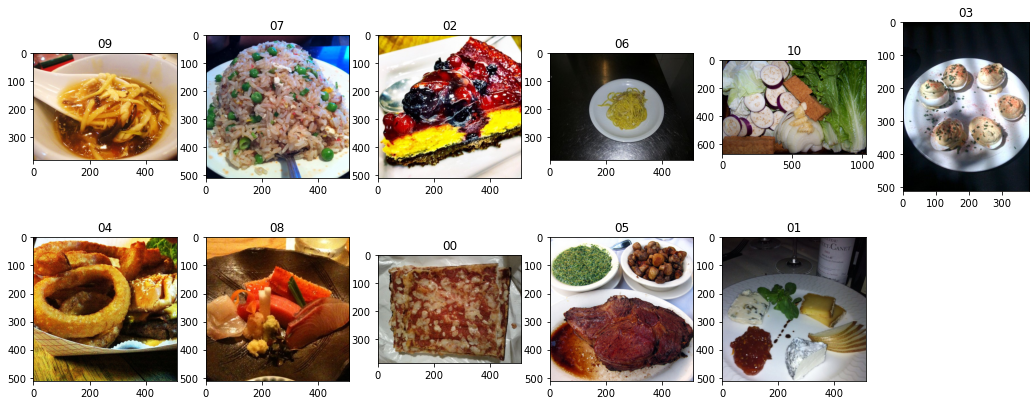

In [97]:
#get sample image(11class) paths
class_img_sample_paths = dict()
for index,(current_path,folder_name,file_name) in  enumerate(os.walk(r'training/labeled')):
    if index == 0:
        continue
    img_path = os.path.join(current_path,file_name[0])
    target_class = current_path[-2:]
    class_img_sample_paths[target_class] = img_path
    
#plot sample image
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.figure(figsize=(18,18))
for img_index,(img_class,img_path) in enumerate(class_img_sample_paths.items()):
    plt.subplot(5,6,img_index+1)
    sample_image = mpimg.imread(img_path)
    plt.title(img_class)
    plt.imshow(sample_image)

In [ ]:
from RandAugment import RandAugment
train_tfm = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.RandomRotation(90),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

test_tfm = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
])

def get_semi_tfm(N,M):
    semi_tfm = transforms.Compose([
        transforms.Resize((128,128)),
        transforms.RandomRotation(45),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])
    semi_tfm.transforms.insert(0, RandAugment(N,M ))
    return semi_tfm

In [98]:
batch_size = 128

train_set = DatasetFolder("training/labeled", loader=lambda x: Image.open(x), extensions="jpg", transform=train_tfm)
valid_set = DatasetFolder("validation", loader=lambda x: Image.open(x), extensions="jpg", transform=test_tfm)
unlabeled_set = DatasetFolder("training/unlabeled", loader=lambda x: Image.open(x), extensions="jpg", transform=test_tfm)
test_set = DatasetFolder("testing", loader=lambda x: Image.open(x), extensions="jpg", transform=test_tfm)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=12, pin_memory=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=12, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

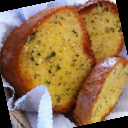

In [101]:
#print example image
to_PIL = transforms.ToPILImage()
to_PIL(train_set[0][0])

In [ ]:
class CNN(nn.Module):
    def __init__(self,input_shape,output_dim):
        super(CNN,self).__init__() # equal to super().__init__()
        #input_shape = (3,128,128)
        cnn_input_dim = input_shape[0] #3
        first_output_dim = 64
        second_output_dim = 128
        third_output_dim = 256
        fourth_output_dim = 512
        cnn_output_dim = 1024
        self.convolution = nn.Sequential(
            nn.Conv2d(cnn_input_dim,first_output_dim,kernel_size = 3,stride = 1, padding = 1),
            nn.BatchNorm2d(first_output_dim),
            nn.ReLU(),
            nn.Conv2d(first_output_dim,first_output_dim,kernel_size = 3,stride = 1, padding = 1),
            nn.BatchNorm2d(first_output_dim),
            nn.ReLU(),
            nn.MaxPool2d(2,stride = 2),
            
            nn.Conv2d(first_output_dim,second_output_dim,kernel_size = 3,stride = 1, padding = 1),
            nn.BatchNorm2d(second_output_dim),
            nn.ReLU(),
            nn.Conv2d(second_output_dim,second_output_dim,kernel_size = 3,stride = 1, padding = 1),
            nn.BatchNorm2d(second_output_dim),
            nn.ReLU(),
            nn.MaxPool2d(2,stride = 2),
            
            nn.Conv2d(second_output_dim,third_output_dim,kernel_size = 3,stride = 1, padding =1),
            nn.BatchNorm2d(third_output_dim),
            nn.ReLU(),
#             nn.Conv2d(third_output_dim,third_output_dim,kernel_size = 3,stride = 1, padding = 1),
#             nn.BatchNorm2d(third_output_dim),
#             nn.ReLU(),
            nn.Conv2d(third_output_dim,third_output_dim,kernel_size = 3,stride = 1, padding = 1),
            nn.BatchNorm2d(third_output_dim),
            nn.ReLU(),
            nn.MaxPool2d(2,stride = 2),
            
            nn.Conv2d(third_output_dim,fourth_output_dim,kernel_size = 3,stride = 1, padding = 1),
            nn.BatchNorm2d(fourth_output_dim),
            nn.ReLU(),
#             nn.Conv2d(fourth_output_dim,fourth_output_dim,kernel_size = 3,stride = 1, padding = 1),
#             nn.BatchNorm2d(fourth_output_dim),
#             nn.ReLU(),
            nn.Conv2d(fourth_output_dim,fourth_output_dim,kernel_size = 3,stride = 1, padding = 1),
            nn.BatchNorm2d(fourth_output_dim),
            nn.ReLU(),
            nn.MaxPool2d(2,stride = 2),
            
            nn.Conv2d(fourth_output_dim,cnn_output_dim,kernel_size = 3,stride = 1,padding = 1),
            nn.BatchNorm2d(cnn_output_dim),
            nn.ReLU(),
#             nn.Conv2d(cnn_output_dim,cnn_output_dim,kernel_size = 3,stride = 1,padding = 1),
#             nn.BatchNorm2d(cnn_output_dim),
#             nn.ReLU(),
            nn.Conv2d(cnn_output_dim,cnn_output_dim,kernel_size = 3,stride = 1,padding = 1),
            nn.BatchNorm2d(cnn_output_dim),
            nn.ReLU(),
            nn.MaxPool2d(2,stride = 2)
        )
        
        self.fc_layers = nn.Sequential(
            nn.Linear(16384,512),
            nn.ReLU(),
            nn.Dropout(.25),
            nn.Linear(512,256),
            nn.ReLU(),
            nn.Dropout(.25),
            nn.Linear(256,128),
            nn.ReLU(),
#             nn.Dropout(.25),
                nn.Linear(128,11)
        )

    def forward(self, x):
        x = self.convolution(x)
        x = x.flatten(1)
        x = self.fc_layers(x)
        return x

In [ ]:
#bigger architecture will improve student's performance
class VGG(nn.Module):
    def __init__(self,input_shape,output_dim,dropout):
        super(VGG,self).__init__()
        #input_shape = (3,128,128)
        cnn_input_dim = input_shape[0] #3
        first_output_dim = 64
        second_output_dim = 128
        third_output_dim = 256
        fourth_output_dim = 512
        cnn_output_dim = 1024
        self.convolution = nn.Sequential(
            nn.Conv2d(cnn_input_dim,first_output_dim,kernel_size = 3,stride = 1, padding = 1),
            nn.BatchNorm2d(first_output_dim),
            nn.ReLU(),
            nn.Conv2d(first_output_dim,first_output_dim,kernel_size = 3,stride = 1, padding = 1),
            nn.BatchNorm2d(first_output_dim),
            nn.ReLU(),
            nn.MaxPool2d(2,stride = 2),
            
            nn.Conv2d(first_output_dim,second_output_dim,kernel_size = 3,stride = 1, padding = 1),
            nn.BatchNorm2d(second_output_dim),
            nn.ReLU(),
            nn.Conv2d(second_output_dim,second_output_dim,kernel_size = 3,stride = 1, padding = 1),
            nn.BatchNorm2d(second_output_dim),
            nn.ReLU(),
            nn.MaxPool2d(2,stride = 2),
            
            nn.Conv2d(second_output_dim,third_output_dim,kernel_size = 3,stride = 1, padding =1),
            nn.BatchNorm2d(third_output_dim),
            nn.ReLU(),
            nn.Conv2d(third_output_dim,third_output_dim,kernel_size = 3,stride = 1, padding = 1),
            nn.BatchNorm2d(third_output_dim),
            nn.ReLU(),
            nn.Conv2d(third_output_dim,third_output_dim,kernel_size = 3,stride = 1, padding = 1),
            nn.BatchNorm2d(third_output_dim),
            nn.ReLU(),
            nn.MaxPool2d(2,stride = 2),
            
            nn.Conv2d(third_output_dim,fourth_output_dim,kernel_size = 3,stride = 1, padding = 1),
            nn.BatchNorm2d(fourth_output_dim),
            nn.ReLU(),
            nn.Conv2d(fourth_output_dim,fourth_output_dim,kernel_size = 3,stride = 1, padding = 1),
            nn.BatchNorm2d(fourth_output_dim),
            nn.ReLU(),
            nn.Conv2d(fourth_output_dim,fourth_output_dim,kernel_size = 3,stride = 1, padding = 1),
            nn.BatchNorm2d(fourth_output_dim),
            nn.ReLU(),
            nn.MaxPool2d(2,stride = 2),
            
            nn.Conv2d(fourth_output_dim,cnn_output_dim,kernel_size = 3,stride = 1,padding = 1),
            nn.BatchNorm2d(cnn_output_dim),
            nn.ReLU(),
            nn.Conv2d(cnn_output_dim,cnn_output_dim,kernel_size = 3,stride = 1,padding = 1),
            nn.BatchNorm2d(cnn_output_dim),
            nn.ReLU(),
            nn.Conv2d(cnn_output_dim,cnn_output_dim,kernel_size = 3,stride = 1,padding = 1),
            nn.BatchNorm2d(cnn_output_dim),
            nn.ReLU(),
            nn.MaxPool2d(2,stride = 2)
        )
        
        self.fc_layers = nn.Sequential(
            nn.Linear(16384,1024),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(1024,512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512,128),
            nn.ReLU(),
            nn.Dropout(.15),
            nn.Linear(128,11)
        )

    def forward(self, x):
        x = self.convolution(x)
        x = x.flatten(1)
        x = self.fc_layers(x)
        return x

In [ ]:
#plot training record
import matplotlib.pyplot as plt
def plot_train_record(train_record_history,print_data_num = True):
    data_num_list = []
    length = len(train_record_history)
    for generation,train_record in enumerate(train_record_history):
        plt.figure(figsize=(16,8))
        plt.subplot(length,2,1)
        plt.ylim(0,3)
        plt.title(f'loss')
        plt.plot(range(len(train_record['train_loss'])),train_record['train_loss'],linestyle='--',c='r',label='train_loss')
        plt.plot(range(len(train_record['val_loss'])),train_record['val_loss'],linestyle='--',label='val_loss')
        plt.legend(loc='upper right',shadow=True)
        plt.subplot(length,2,2)
        plt.ylim(.2,1)
        plt.title(f'acc')
        plt.plot(range(len(train_record['train_acc'])),train_record['train_acc'],c='r',label='train_acc')
        plt.plot(range(len(train_record['val_acc'])),train_record['val_acc'],label='val_acc')
        plt.legend(loc='lower right',shadow=True)
        plt.show()
    
    if print_data_num:
        plt.title('training num')
        plt.plot(range(len(train_record['data_num'])),train_record['data_num'],c='r',label='data_num')
        plt.legend(loc='lower right',shadow=True)
        plt.show()

In [ ]:
from torch.utils.data import ConcatDataset,Dataset
class custom_dataset(Dataset):
    def __init__(self,x,y,transform):
        self.x = x
        self.y = y
        self.transform = transform
        self.to_PIL = transforms.ToPILImage()
        
    def __getitem__(self,index):
        return self.transform(self.to_PIL(self.x[index])),self.y[index]
        
    def __len__(self):
        return len(self.x)

In [ ]:
def get_semi_dataset(model,device,unlabeled_dataset,threshold,class_data_limit,transforms):
    model.eval()
    unlabeled_dataloader = DataLoader(unlabeled_dataset, batch_size=batch_size, shuffle=False, num_workers=12, pin_memory=True)
    
    softmax = nn.Softmax(dim = 1)
    data_each_class = {k : torch.tensor([]) for k in range(11)}
    data_prob_each_class = {k : torch.tensor([]) for k in range(11)}
    for data in unlabeled_dataloader:
        x_cpu,_ = data
        x = x_cpu.to(device)

        with torch.no_grad():
            logit = model(x)
        probs = softmax(logit)
        #filter data with confidence
        for index,prob in enumerate(probs): 
            if prob.max() > threshold:
                cls = prob.argmax().item()
                data_each_class[cls] = torch.cat((data_each_class[cls],x_cpu[index].unsqueeze(0)),0)
                data_prob_each_class[cls] = torch.cat((data_prob_each_class[cls],prob.max().to('cpu').unsqueeze(0)),0)

    #balancing data, data number of each class should equals class_data_limit
    pseudo_data = torch.tensor([])
    pseudo_label = []
    for cls,data_list in data_each_class.items():
        data_length = len(data_list)
        print(f"class:{cls},data number:{data_length}")
        if data_length == 0:
            continue
        if data_length > class_data_limit:#pick top-class_data_limit confidence data
            prob_list = data_prob_each_class[cls]
            sorted_data_list = [data for _,data in sorted(zip(prob_list,data_list),key=lambda pair:pair[0])] #use prob_list to sort data_list
            sorted_data_list.reverse()
            data_each_class[cls] = torch.tensor([item.detach().numpy() for item in sorted_data_list[:class_data_limit]]) #pick top-class_data_limit data
        while len(data_each_class[cls]) < class_data_limit: #random duplicate data
            data_to_append = data_list[random.randint(0,data_length-1)].unsqueeze(0)
            data_each_class[cls] = torch.cat((data_each_class[cls],data_to_append),0)
        pseudo_label += [cls]*class_data_limit

    for class_data in data_each_class.values():
        pseudo_data = torch.cat((pseudo_data,class_data),0)


    semi_dataset = custom_dataset(pseudo_data,pseudo_label,transforms)

    return semi_dataset

In [ ]:
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
input_sample,target_sample = [s[0] for s in next(iter(train_loader))]
max_generation = 8
start_semi = False
train_record_history = []
n_epochs = 90
semi_threshold = .65
min_lr = 8e-6
early_stopping_by_loss_threshold = 5
early_stopping_by_avgloss_threshold = 4
class_num_limit_dict = {0:50,
                        1:100,
                        2:150,
                        3:250,
                        4:400,
                       'base':550}
lr_dict = {0:4e-4,
           1:1e-4,
           2:1e-5,
           3:1e-6,
           'base':1e-7
}

for generation in range(max_generation):
    #set params for each generation
    previous_loss = 100 #for early-stopping
    previous_avg_loss = 100 #for auto-scaling learning rate
    avg_loss_5_epoch = 0
    avg_loss_list = []
    five_epoch_index = -1
    train_record = {'train_loss':[],'train_acc':[],'val_loss':[],'val_acc':[],'data_num':[]}
    class_data_limit = class_num_limit_dict[generation] if generation in class_num_limit_dict else class_num_limit_dict['base']
    lr = lr_dict[generation] if generation in lr_dict else lr_dict['base']
    criterion = nn.CrossEntropyLoss()
    if start_semi and len(concat_dataset) > 5500:
        dropout_ratio = .3 if data_num <7500 else .35
        model = VGG(input_sample.shape,11,dropout_ratio)
    else:
        model = CNN(input_sample.shape,11)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    model.to(device)
    lowest_acc = 0
    avg_acc_5_epoch = 0
    store_model = False
    
    
    # ---------- Training ----------
    for epoch in range(n_epochs)
        model.train()
        train_loss = []
        train_accs = []
        for batch in train_loader:
            imgs, labels = batch
            logits = model(imgs.to(device))
            loss = criterion(logits, labels.to(device))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()
            train_loss.append(loss.detach().item())
            train_accs.append(acc)

        train_loss = sum(train_loss) / len(train_loss)
        train_acc = sum(train_accs) / len(train_accs)

        lr_decay_rate = .955
        param_group = optimizer.param_groups[0]
        if param_group['lr'] > min_lr:
            param_group['lr'] *= lr_decay_rate

        # ---------- Validation ----------
        model.eval()
        valid_loss = []
        valid_accs = []

        for batch in valid_loader:
            imgs, labels = batch
            with torch.no_grad():
                logits = model(imgs.to(device))
            loss = criterion(logits, labels.to(device))
            acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()
            valid_loss.append(loss.detach().item())
            valid_accs.append(acc)

        valid_loss = sum(valid_loss) / len(valid_loss)
        valid_acc = sum(valid_accs) / len(valid_accs)
        avg_acc_5_epoch += valid_acc

        if valid_acc > lowest_acc:
            lowest_acc = valid_acc
            if epoch > 50:
                loaded_path = f"model/G_{generation}_0415"
                torch.save(model.state_dict(),loaded_path)
                store_model = True

        #prepare tensorboard
        train_record['train_loss'].append(train_loss)
        train_record['train_acc'].append(train_acc)
        train_record['val_loss'].append(valid_loss)
        train_record['val_acc'].append(valid_acc)

        print(f"[{epoch + 1:03d}/{n_epochs:03d}] lr = {param_group['lr']:.7f} [Train] loss = {train_loss:.5f}, acc = {train_acc:.5f} | [Valid] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")

        #early stopping
        if valid_loss > previous_loss:
            trigger_times += 1
            if trigger_times >= early_stopping_by_loss_threshold:
                print('Early Stop by loss')
                break # break this generation
        else:
            trigger_times = 0
        previous_loss = valid_loss

        #auto-scalling learing rate
        avg_loss_5_epoch += valid_loss
        if (epoch+1) % 5 == 0:
            avg_loss_5_epoch /= 5
            avg_acc_5_epoch /= 5
            avg_loss_list.append(avg_loss_5_epoch)
            five_epoch_index += 1
            print(f"[Avg_Loss] = {avg_loss_5_epoch:.5f} | [Avg_Acc] = {avg_acc_5_epoch:.5f}")

            if previous_avg_loss < avg_loss_5_epoch:
                param_group['lr'] *= .85
                print(f"drop lr to : {param_group['lr']}")
            if len(avg_loss_list) >= 4:
                avg_loss_increasing_0_2 = (avg_loss_list[five_epoch_index] > avg_loss_list[five_epoch_index-1]) and (avg_loss_list[five_epoch_index-1] > avg_loss_list[five_epoch_index-2])
                avg_loss_increasing_2_4 = (avg_loss_list[five_epoch_index-2] > avg_loss_list[five_epoch_index-3]) and (avg_loss_list[five_epoch_index-3] > avg_loss_list[five_epoch_index-4])
                if avg_loss_increasing_0_2 and avg_loss_increasing_2_4:
                    print('Early Stop by avg loss')
                    break # break this generation
            previous_avg_loss = avg_loss_5_epoch
            avg_loss_5_epoch = 0
            avg_acc_5_epoch = 0

    #----end of one generation
    plot_train_record([train_record],print_data_num = False)

    
    # ---------- Noisy Student----------
    start_semi = True
    if store_model:
        model.load_state_dict(torch.load(loaded_path))
        print("load model")
    
    N = 3 + generation 
    M = 10 + generation*2
    semi_tfm = get_semi_tfm(N,M)
    pseudo_set = get_semi_dataset(model,device,unlabeled_set,semi_threshold,class_data_limit,semi_tfm)
    concat_dataset = ConcatDataset([train_set, pseudo_set])
    train_loader = DataLoader(concat_dataset, batch_size=batch_size, shuffle=True, num_workers=12, pin_memory=True)

    #record
    data_num = len(concat_dataset)
    train_record['data_num'].append(data_num)
    train_record_history.append(train_record)
    print(f"new data number : {data_num}")
    
torch.save(model,'model/0414')

In [ ]:
plot_train_record([train_record])

In [ ]:
def predict(model,test_dataloader,device):
#     softmax = nn.Softmax(dim = 1)
    prediction = []
    model.eval()
    for data in test_dataloader:
        x,y = [d.to(device) for d in data]
        with torch.no_grad():
            logit = model(x)
        max_prob,target_class = torch.max(logit,dim = 1)
        prediction.extend(target_class.cpu().tolist())
    return prediction
    
def load_model(model_arch,path):
    model_arch.load_state_dict(torch.load(path))
    model_arch.eval()
    return model_arch
    
if 'model' not in locals(): # if model not instantiate, load from local
    print("load model")
    input_sample,target_sample = [s[0] for s in next(iter(train_dataloader))]
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model_arch = CNN(input_sample.shape,11).to(device)
    model = load_model(model_arch,'model/0414')
    
answer = predict(model,test_loader,device)

In [ ]:
#make submit csv file
file_id = []
for current_path,current_folder_paths,current_file_names in os.walk(r'testing/00'):
    for file_name in current_file_names:
        file_id.append(os.path.splitext(file_name)[0])
file_id.sort()

answer_df = pd.DataFrame({'Id':file_id,'Category':answer})
answer_df.to_csv('answer/answer0410.csv',index = False)
answer_df.head()
